# (Variational) Convolutional Autoencoder for CelebA and Mnist using torch


# Import Pytorch and other libraries

In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
np.random.seed(0)
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn
from sklearn import metrics

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset


# Load CelebA

Here we download a zipfile of images and their attributes
that have been preprocessed to 64x64 using the script at
https://github.com/probml/pyprobml/blob/master/scripts/celeba_kaggle_preprocess.py



In [3]:
# N can be 200, 20000, or 40000
N = 20000
H = 64; W = 64; C = 3;
input_shape = [H, W, 3]
name = 'celeba_small_H{}_W{}_N{}'.format(H, W, N)
csv_name = '{}.csv'.format(name)
zip_name = '{}.zip'.format(name)

In [4]:
!rm {csv_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{csv_name}  

rm: cannot remove 'celeba_small_H64_W64_N20000.csv': No such file or directory
--2021-04-26 16:27:24--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2440084 (2.3M) [text/plain]
Saving to: ‘celeba_small_H64_W64_N20000.csv’

celeba_small_H64_W6 100%[===================>]   2.33M  --.-KB/s    in 0.1s    

2021-04-26 16:27:26 (16.9 MB/s) - ‘celeba_small_H64_W64_N20000.csv’ saved [2440084/2440084]



In [5]:
df = pd.read_csv(csv_name)
df.head()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,...,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
print(list(df.columns))

['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [7]:
N = len(df)
print(N)

20000


In [8]:
!rm {zip_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{zip_name}
  

rm: cannot remove 'celeba_small_H64_W64_N20000.zip': No such file or directory
--2021-04-26 16:27:26--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34148268 (33M) [application/zip]
Saving to: ‘celeba_small_H64_W64_N20000.zip’

celeba_small_H64_W6 100%[===================>]  32.57M  58.7MB/s    in 0.6s    

2021-04-26 16:27:29 (58.7 MB/s) - ‘celeba_small_H64_W64_N20000.zip’ saved [34148268/34148268]



In [9]:
!rm *.jpg
!ls

rm: cannot remove '*.jpg': No such file or directory
celeba_small_H64_W64_N20000.csv  celeba_small_H64_W64_N20000.zip  sample_data


In [10]:
!unzip -qq {zip_name}

In [11]:
from glob import glob
filenames = glob('*.jpg')
#print(filenames) # should match df['image_id']
print(len(filenames))

20000


In [12]:
from matplotlib.image import imread
images_celeba = np.zeros((N, H, W, C), dtype=np.float32) # pre-allocate memory
for i in range(N):
    filename = df.iloc[i]['image_id']
    img = imread(filename) # numpy array of uint8
    images_celeba[i,:,:,:] = img / 255

In [13]:
class Celeba_ds(Dataset):

  def __init__(self, images):
    self.X = images

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, index):
        image = self.X[index]
        X = self.transform(image)
        return X
  
  transform=transforms.Compose([
        transforms.ToTensor(),
        ])

# annotated.
class Celeba_ano_ds(Dataset):

  def __init__(self, images, labels):
    self.X = images
    self.labels = labels

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, index):
        image = self.X[index]
        label = self.labels[index]
        X = self.transform(image)
        sample = (X,label)
        return sample
  
  transform=transforms.Compose([
        transforms.ToTensor(),
        ])


In [14]:
celeba_dataset = Celeba_ds(images_celeba)
celeba_train_loader = DataLoader(
        celeba_dataset,batch_size= 32,shuffle=False)

celeba_test_loader = celeba_train_loader


# Load MNIST

In [15]:
mnist_train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True,download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])),batch_size= 64)

mnist_test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False,download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # rescales channels to [0,1]
        ])),batch_size= 64)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [16]:
print(type(mnist_train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


# Inspect dataset

In [17]:
def inspect_data(data_loader, max_batches=4, is_labeled=True):
  if is_labeled:
    for batch, (X,y) in enumerate(data_loader):
      if batch == 4:
        break
      print('batch#{}, X size {}, Y size {}'.format(batch, X.shape, y.shape))
  else:
    for batch, X in enumerate(data_loader):
      if batch == 4:
        break
      print('batch#{}, X size {}'.format(batch, X.shape)) 

inspect_data(mnist_test_loader)
inspect_data(celeba_test_loader,is_labeled=False)

def extract_sampledata(data_loader,max_n=4, is_labeled=True):
  if is_labeled:
    X,y = next(iter(data_loader))
    return X[:max_n], y[:max_n]
  else:
    X = next(iter(data_loader))
    return X[:max_n]

Xsmall_celeba = extract_sampledata(celeba_test_loader,is_labeled=False)
Xsmall_mnist, ysmall_mnist =  extract_sampledata(mnist_test_loader)
print(torch.transpose(torch.transpose(Xsmall_celeba,1,3),1,2).shape)
print(Xsmall_mnist.shape)


batch#0, X size torch.Size([64, 1, 28, 28]), Y size torch.Size([64])
batch#1, X size torch.Size([64, 1, 28, 28]), Y size torch.Size([64])
batch#2, X size torch.Size([64, 1, 28, 28]), Y size torch.Size([64])
batch#3, X size torch.Size([64, 1, 28, 28]), Y size torch.Size([64])
batch#0, X size torch.Size([32, 3, 64, 64])
batch#1, X size torch.Size([32, 3, 64, 64])
batch#2, X size torch.Size([32, 3, 64, 64])
batch#3, X size torch.Size([32, 3, 64, 64])
torch.Size([4, 64, 64, 3])
torch.Size([4, 1, 28, 28])


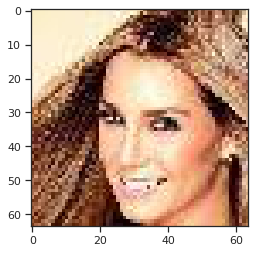

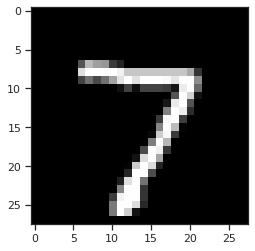

In [18]:
def imshow2(img):
  C,H,W = img.shape
  if C == 1:
     plt.imshow(img[0, :, :], cmap='gray')
  else:
    plt.imshow(torch.transpose(torch.transpose(img,0,2),0,1)[:,:,:])
  plt.show()

imshow2(Xsmall_celeba[0,:])
imshow2(Xsmall_mnist[0,:])

# Define model

In [19]:
def same_padding(strides,transpose=False):
  if transpose:
    if strides==1:
      padding =1
      dilation = 1
      output_padding = 0
    elif strides==2:
      padding =2
      dilation = 2
      output_padding = 1
    return padding,dilation,output_padding

  else:
    padding =1 
    return padding


In [119]:
class va_encoder(nn.Module):
  def __init__(self,
               input_shape,
               z_dim,
               encoder_conv_filters, 
               encoder_conv_kernel_size, 
               encoder_conv_strides,
               use_batch_norm=False,
               use_dropout= False,
               autoencoder = False):
    super().__init__()
    self.input_shape = input_shape
    self.z_dim = z_dim
    self.encoder_conv_filters = encoder_conv_filters
    self.encoder_conv_kernel_size = encoder_conv_kernel_size
    self.encoder_conv_strides = encoder_conv_strides
    self.autoencoder = autoencoder
    self.leak_relu = nn.LeakyReLU() 
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    self.conv2Ds = []
    all_layers = [self.input_shape[0]] + self.encoder_conv_filters
    
    for i in range(len(self.encoder_conv_filters)):
          self.conv2Ds.append(self.conv2D(all_layers[i],
                                     all_layers[i+1],
                                     self.encoder_conv_kernel_size[i],
                                     self.encoder_conv_strides[i]))
          self.register_parameter('conv2d{}_weight'.format(i),
                                  self.conv2Ds[i].weight)
          self.register_parameter('conv2d_{}_bias'.format(i),
                                  self.conv2Ds[i].bias)
             

    self.register_parameter('mu_weight',None)
    self.register_parameter('mu_bias',None)
    self.register_parameter('logvar_weight',None)
    self.register_parameter('logvar_bias',None)


  def conv2D(self, in_features, out_features,kernel_size, strides):
    padding = same_padding(strides)
    return nn.Conv2d(in_features,out_features,kernel_size=kernel_size,stride=strides,padding=1)
  
  def reset_parameter(self, input):
        return nn.Parameter(input.new(input.size()).normal_(0, 1))

  def forward(self, X):
    out = X
    all_layers = [self.input_shape[0]] + self.encoder_conv_filters
    
    for i in range(len(self.encoder_conv_filters)):
      out = self.conv2Ds[i](out)
      
      if self.use_batch_norm:
        out = nn.BatchNorm2d(all_layers[i+1])(out)

      out = self.leak_relu(out)

      if self.use_dropout:
        out = nn.Dropout()(out)
        
    
    self.shape_before_flattening = out.shape

    out = nn.Flatten()(out)

    self.mu_linear = nn.Linear(out.shape[-1],self.z_dim)
    mu = self.mu_linear(out)
    if self.mu_weight is None:
            self.mu_weight = self.mu_linear.weight
    if self.mu_bias is None:
            self.mu_bias = self.mu_linear.bias

    if self.autoencoder:
      encoder = mu
    else:
      self.logvar_linear = nn.Linear(out.shape[-1],self.z_dim)
      log_var = nn.Linear(out.shape[-1],self.z_dim)(out)

      if self.logvar_weight is None:
          self.logvar_weight = self.logvar_linear.weight
      if self.logvar_bias is None:
          self.logvar_bias = self.logvar_linear.bias

      encoder = (mu,log_var)
    

    return encoder

In [123]:
def test_encoder():
  latent_dim = 2
  for Xsmall in [Xsmall_celeba,Xsmall_mnist]:
    encoder_model = va_encoder(Xsmall[0,:].shape,
                               latent_dim,
                               [32,64],
                               [3,3],
                               [2,2])
    (Mu,log_var) = encoder_model(Xsmall)
    Nz,Cz,Hc,Wz = encoder_model.shape_before_flattening
    assert(Cz==64)
    N, C, H, W = Xsmall.shape
    for name, param in encoder_model.named_parameters():
      if param.requires_grad:
          print(name,param.shape)
    assert(list(Mu.shape)==[N,latent_dim])
    print('-----')

test_encoder()


conv2d0_weight torch.Size([32, 3, 3, 3])
conv2d_0_bias torch.Size([32])
conv2d1_weight torch.Size([64, 32, 3, 3])
conv2d_1_bias torch.Size([64])
mu_weight torch.Size([2, 16384])
mu_bias torch.Size([2])
logvar_weight torch.Size([2, 16384])
logvar_bias torch.Size([2])
-----
conv2d0_weight torch.Size([32, 1, 3, 3])
conv2d_0_bias torch.Size([32])
conv2d1_weight torch.Size([64, 32, 3, 3])
conv2d_1_bias torch.Size([64])
mu_weight torch.Size([2, 3136])
mu_bias torch.Size([2])
logvar_weight torch.Size([2, 3136])
logvar_bias torch.Size([2])
-----


In [115]:
class va_decoder(nn.Module):
  def __init__(self,
        shape_before_flattening,
        z_dim,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        use_batch_norm = False,
        use_dropout= False
        ):
    super().__init__()
    self.shape_before_flattening = shape_before_flattening
    self.z_dim = z_dim
    self.decoder_conv_t_filters = decoder_conv_t_filters
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
    self.decoder_conv_t_strides = decoder_conv_t_strides
    self.leak_relu = nn.LeakyReLU()
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    self.conv_t_2Ds = []
    all_layers = [shape_before_flattening[1]] + self.decoder_conv_t_filters
    conv_t_layers = len(self.decoder_conv_t_filters)

    for i in range(conv_t_layers):
        self.conv_t_2Ds.append(self.conv_trans2D(all_layers[i],
                                all_layers[i+1],
                                self.decoder_conv_t_kernel_size[i],
                                self.decoder_conv_t_strides[i]))
        self.register_parameter('conv2d_t_{}_weight'.format(i),
                                  self.conv_t_2Ds[i].weight)
        self.register_parameter('conv2d_t_{}_bias'.format(i),
                                  self.conv_t_2Ds[i].bias)

    self.linear = nn.Linear(self.z_dim,np.prod(self.shape_before_flattening[1:]))
    self.register_parameter('dense_weight',self.linear.weight)
    self.register_parameter('dense_bias',self.linear.bias)

  def conv_trans2D(self, in_features, out_features,kernel_size, strides):
    
    padding, dilation, output_padding = same_padding(strides,transpose=True)
    return nn.ConvTranspose2d(in_features,out_features,
                              kernel_size=kernel_size,
                              stride=strides,
                              padding=padding,
                              dilation=dilation,
                              output_padding=output_padding)
  
  def forward(self, X):
    out = X
    out = nn.Linear(self.z_dim,np.prod(self.shape_before_flattening[1:]))(out)

    out = out.reshape(list(self.shape_before_flattening))
   
    all_layers = [out.shape[1]] + self.decoder_conv_t_filters
    conv_layers = len(self.decoder_conv_t_filters)
    for i in range(conv_layers):
        out = self.conv_t_2Ds[i](out)

        if i < conv_layers - 1:
           if self.use_batch_norm:
              out = nn.BatchNorm2d(all_layers[i+1])(out)
           
           out = self.leak_relu(out)
           
           if self.use_dropout:
              out = nn.Dropout()(out)            
    
    decoder = out
    return decoder

In [124]:
def test_decoder():
  latent_dim = 2
  for Xsmall in [Xsmall_celeba,Xsmall_mnist]:
    N, C, H, W = Xsmall.shape
    encoder_model = va_encoder(Xsmall[0,:].shape,
                               latent_dim,
                               [32,64],
                               [3,3],
                               [2,2],
                               autoencoder=True)
    Mu = encoder_model(Xsmall)
    decoder_model = va_decoder(encoder_model.shape_before_flattening,
                               latent_dim,
                               [64,32,C],
                               [3,3,3],
                               [2,2,1])
    
    assert(Mu.shape == (N, latent_dim))
    Xrecon = decoder_model(Mu)
    for name, param in decoder_model.named_parameters():
      if param.requires_grad:
          print(name,param.shape)
    print(Xrecon.shape)
    print(Xsmall.shape)
    print('-----')
    assert(Xrecon.shape==Xsmall.shape)

test_decoder()

conv2d_t_0_weight torch.Size([64, 64, 3, 3])
conv2d_t_0_bias torch.Size([64])
conv2d_t_1_weight torch.Size([64, 32, 3, 3])
conv2d_t_1_bias torch.Size([32])
conv2d_t_2_weight torch.Size([32, 3, 3, 3])
conv2d_t_2_bias torch.Size([3])
dense_weight torch.Size([16384, 2])
dense_bias torch.Size([16384])
torch.Size([4, 3, 64, 64])
torch.Size([4, 3, 64, 64])
-----
conv2d_t_0_weight torch.Size([64, 64, 3, 3])
conv2d_t_0_bias torch.Size([64])
conv2d_t_1_weight torch.Size([64, 32, 3, 3])
conv2d_t_1_bias torch.Size([32])
conv2d_t_2_weight torch.Size([32, 1, 3, 3])
conv2d_t_2_bias torch.Size([1])
dense_weight torch.Size([3136, 2])
dense_bias torch.Size([3136])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
-----


In [25]:
def sample_gauss(mean,logvar):
  return torch.normal(mean, torch.exp(logvar * .5))

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = np.log(2. * np.pi)
  return torch.sum(
      -.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi),
      raxis)


In [26]:
class ConvVAE(nn.Module):
  def __init__(self,
        input_dim,
        latent_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        use_batch_norm = False,
        use_dropout= False,
        recon_loss_scaling = 1,
        kl_loss_scaling = 1,
        use_mse_loss = False,
        autoencoder = False,
        model_name = None
        ):
    super(ConvVAE, self).__init__()
    # Save all args so we can reconstruct this object later
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.encoder_conv_filters = encoder_conv_filters
    self.encoder_conv_kernel_size = encoder_conv_kernel_size
    self.encoder_conv_strides = encoder_conv_strides
    self.decoder_conv_t_filters = decoder_conv_t_filters
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
    self.decoder_conv_t_strides = decoder_conv_t_strides
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout
    self.recon_loss_scaling = recon_loss_scaling
    self.kl_loss_scaling = kl_loss_scaling
    self.use_mse_loss = use_mse_loss
    self.autoencoder = autoencoder
    self.nepochs = 0
    if model_name:
      self.model_name = model_name
    else:
      model_name = 'det{}_dim{}'.format(autoencoder, latent_dim)
      self.model_name = model_name
    
    self.inference_net = va_encoder(
        input_dim,
        latent_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        use_batch_norm,
        use_dropout,
        autoencoder)
    
    self.inference_net(torch.randn([1]+list(input_dim)))
    self.shape_before_flattening = self.inference_net.shape_before_flattening
  
    self.generative_net = va_decoder(
        self.shape_before_flattening,
        latent_dim,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        use_batch_norm,
        use_dropout)
    
  def sample(self, nsamples=1):
      eps = torch.random.normal(torch.zeros([nsamples, self.latent_dim]))
      return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
      if self.autoencoder:
        return self.inference_net(x)
      mean, logvar = self.inference_net(x)
      return mean

  def decode(self, z, apply_sigmoid=True):
      self.generative_net.shape_before_flattening = [z.shape[0]] + list(self.inference_net.shape_before_flattening[1:])
      logits = self.generative_net(z)
      if apply_sigmoid:
        probs = torch.sigmoid(logits)
        return probs
      return logits
    
  def encode_stochastic(self, x):
      if self.autoencoder:
        raise Exception('AE cannot encode stochastically')
      mean, logvar = self.inference_net(x)
      return sample_gauss(mean, logvar)

  def compute_loss(self, x):
      if self.autoencoder:
        z = self.inference_net(x)
      else:
        mean, logvar = self.inference_net(x)
        z = sample_gauss(mean, logvar)

      if self.use_mse_loss:
        x_probs = self.decode(z, apply_sigmoid=True)
        logpx_z = -0.5*nn.MSELoss()(x,x_probs)
      
      else:
        x_logit = self.decode(z, apply_sigmoid=False)
        loss = x*-torch.log(torch.sigmoid(x_logit)) + (1-x)*-torch.log(1-torch.sigmoid(x_logit))
        logpx_z = -torch.sum(loss,(1,2,3))
      
      if self.autoencoder:
        kl_loss = 0
      else:
        logpz = log_normal_pdf(z, torch.zeros(mean.shape), torch.zeros(logvar.shape)) # prior: mean=0, logvar=0
        logqz_x = log_normal_pdf(z, mean, logvar)
        kl_loss = logpz - logqz_x # single sample MC approximation
        
      return -torch.mean(self.recon_loss_scaling * logpx_z + self.kl_loss_scaling * kl_loss) # -ve ELBO

      

# Create models

In [27]:
# Use parameters from
#https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_05_vae_faces_train.ipynb

encoder_conv_filters=[32,64,64, 64]
encoder_conv_kernel_size=[3,3,3,3]
encoder_conv_strides=[2,2,2,2]
decoder_conv_t_filters=[64,64,32,3]
decoder_conv_t_kernel_size=[3,3,3,3]
decoder_conv_t_strides=[2,2,2,2]

N, C, H, W = Xsmall_celeba.shape
input_shape = (C,H,W)

names = ['2d_det', '200d_det', '2d_stoch', '200d_stoch']
deterministic = [True, True, False, False]
latent_dims = [2, 200, 2, 200]
models_celeba = []

for i in range(4):
  model = ConvVAE(
            input_dim = input_shape,
            latent_dim = latent_dims[i],
            encoder_conv_filters=encoder_conv_filters,
            encoder_conv_kernel_size=encoder_conv_kernel_size,
            encoder_conv_strides=encoder_conv_strides,
            decoder_conv_t_filters=decoder_conv_t_filters,
            decoder_conv_t_kernel_size=decoder_conv_t_kernel_size,
            decoder_conv_t_strides=decoder_conv_t_strides,
            use_batch_norm=True,
            use_dropout=True,
            use_mse_loss = True,
            recon_loss_scaling = 10000,
            autoencoder = deterministic[i],
            model_name = names[i])
  print(model)
  models_celeba.append(model)

model_dict_celeba = {}
for model in models_celeba:
  model_dict_celeba[model.model_name] = model

ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=2, out_features=1024, bias=True)
  )
)
ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=200, out_features=1024, bias=True)
  )
)
ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=2, out_features=1024, bias=True)
  )
)
ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=200, out_features=1024, bias=True)
  )
)


In [28]:

# For MNIST, use parameters from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb

N, C, H, W = Xsmall_mnist.shape
input_shape = (C,H,W)

if 0:
  encoder_conv_filters = [32,64]
  encoder_conv_kernel_size = [3,3]
  encoder_conv_strides = [2,2]
  decoder_conv_t_filters = [64,32,C]
  decoder_conv_t_kernel_size = [3,3,3]
  decoder_conv_t_strides = [2,2,1]
else:
  encoder_conv_filters = [32,64,64, 64]
  encoder_conv_kernel_size = [3,3,3,3]
  encoder_conv_strides = [1,2,2,1]
  decoder_conv_t_filters = [64,64,32,C]
  decoder_conv_t_kernel_size = [3,3,3,3]
  decoder_conv_t_strides = [1,2,2,1]

names = ['2d_det', '20d_det', '2d_stoch', '20d_stoch']
deterministic = [True, True, False, False]
latent_dims = [2, 20, 2, 20]
models_mnist = []
for i in range(4):
  model = ConvVAE(
      input_dim = input_shape,
      encoder_conv_filters = encoder_conv_filters,
      encoder_conv_kernel_size = encoder_conv_kernel_size,
      encoder_conv_strides = encoder_conv_strides,
      decoder_conv_t_filters = decoder_conv_t_filters,
      decoder_conv_t_kernel_size = decoder_conv_t_kernel_size,
      decoder_conv_t_strides = decoder_conv_t_strides,
      latent_dim = latent_dims[i],
      recon_loss_scaling = 1000,
      use_mse_loss = True, 
      autoencoder = deterministic[i],
      model_name = names[i])
  print(model)
  models_mnist.append(model)


model_dict_mnist = {}
for model in models_mnist:
  model_dict_mnist[model.model_name] = model

ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=2, out_features=3136, bias=True)
  )
)
ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=20, out_features=3136, bias=True)
  )
)
ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=2, out_features=3136, bias=True)
  )
)
ConvVAE(
  (inference_net): va_encoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
  )
  (generative_net): va_decoder(
    (leak_relu): LeakyReLU(negative_slope=0.01)
    (linear): Linear(in_features=20, out_features=3136, bias=True)
  )
)


In [29]:
def test_vae(model, Xsmall):
  print('testing {}'.format(model.model_name))
  print(Xsmall.shape)
  Z = model.encode(Xsmall)
  predictions = model.decode(Z)
  assert(predictions.shape == Xsmall.shape)
  L = model.compute_loss(Xsmall)

for model in models_celeba:
  test_vae(model, Xsmall_celeba)

  
for model in models_mnist:
  test_vae(model, Xsmall_mnist)



testing 2d_det
torch.Size([4, 3, 64, 64])
testing 200d_det
torch.Size([4, 3, 64, 64])
testing 2d_stoch
torch.Size([4, 3, 64, 64])
testing 200d_stoch
torch.Size([4, 3, 64, 64])
testing 2d_det
torch.Size([4, 1, 28, 28])
testing 20d_det
torch.Size([4, 1, 28, 28])
testing 2d_stoch
torch.Size([4, 1, 28, 28])
testing 20d_stoch
torch.Size([4, 1, 28, 28])


# Training


In [30]:
def train_model(model, optmizer, train_loader, epochs, islabeled=False, callback=None, *args):
    start = time.time()

    for epoch in range(epochs):
      for batch in train_loader:
        if islabeled:
          (X,y) = batch
        else:
          X = batch
        optmizer.zero_grad()
        loss = model.compute_loss(X)
        loss.backward()
        optmizer.step()
      if callback:
        callback(model, epoch, loss, X, *args)
    
    end = time.time()
    elapsed = end - start
    model.nepochs +=epochs
    return model, elapsed


In [31]:
model = model_dict_mnist['2d_det']
print(len(list(model.parameters())))

16


In [32]:
def callback(model, epoch, loss, X, a, b):
  print('epoch {}, loss {}, X shape {}, a {}, b {}'.format(epoch, loss, X.shape,  a, b))

a=1; b = 2;
epochs = 1

model = model_dict_mnist['2d_det']
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model = train_model(model, optimizer, mnist_train_loader, epochs, True, callback, a, b)

model = model_dict_celeba['2d_stoch']
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model = train_model(model, optimizer, celeba_train_loader, epochs, False, callback, a, b)

epoch 0, loss 499.780517578125, X shape torch.Size([32, 1, 28, 28]), a 1, b 2
epoch 0, loss 483.5856628417969, X shape torch.Size([32, 3, 64, 64]), a 1, b 2


In [33]:
print(model_dict_mnist['2d_det'].nepochs)
print(model_dict_mnist['2d_stoch'].nepochs)

print(model_dict_celeba['2d_det'].nepochs)
print(model_dict_celeba['2d_stoch'].nepochs)

1
0
0
1


In [44]:

# Callback

# We use fixed noise vector to generate samples during training so
# it will be easier to see the improvement.
num_examples_to_generate = 16
noise_dict = {}
for dim in [2, 20, 200]:
  noise = torch.normal(torch.zeros(num_examples_to_generate, dim))
  noise_dict[dim] = noise

def show_images_2d_grid(images, max_images = 16, ttl=''):
  N, H, W, C = np.shape(images)
  N = np.minimum(N, max_images)
  n = int(np.ceil(np.sqrt(N)))
  fig = plt.figure(figsize=(n,n))
  for i in range(N):
      plt.subplot(n, n, i+1)
      if C == 1:
         plt.imshow(images[i, :, :, 0], cmap='gray')
      else:
         plt.imshow(images[i, :, :, :])
      plt.axis('off')
  plt.suptitle(ttl)
  plt.show()

def show_images(images, max_images = 6, ttl=''):
  images = images.detach()
  N, C, H, W = images.shape
  N = np.minimum(N, max_images)
  fig, axs = plt.subplots(1, N, figsize=(10,5))
  for i in range(N):
    ax = axs[i]
    if C == 1:
      ax.imshow(images[i,:][0, :, :], cmap='gray')
    else:
      ax.imshow(torch.transpose(torch.transpose(images[i,:],0,2),0,1)[:, :, :])
    ax.axis('off')
  plt.suptitle(ttl)
  plt.tight_layout()
  plt.show()

def generate_images(model, ttl='', max_images=6):
  # Noise vector should be N * L, where L is num latent dimensions
  L = model.latent_dim
  noise = noise_dict[L]
  predictions = model.decode(noise)
  show_images(predictions, ttl=ttl)
  
def reconstruct_images(model, images, ttl='', max_images=6):
  Z = model.encode(images)
  predictions = model.decode(Z)
  #show_images(images, ttl=ttl)
  #show_images(predictions, ttl=ttl)
  predictions = predictions.detach()
  N, C, H, W = images.shape
  N = np.minimum(N, max_images)
  fig, axs = plt.subplots(2, N, figsize=(10,5))
  for i in range(N):
    ax = axs[0,i]
    if C == 1:
      ax.imshow(images[i,:][0, :, :], cmap='gray')
    else:
      ax.imshow(torch.transpose(torch.transpose(images[i,:],0,2),0,1)[:, :, :])
    ax.axis('off')
    ax = axs[1,i]
    if C == 1:
      ax.imshow(predictions[i,:][0, :, :], cmap='gray')
    else:
      ax.imshow(torch.transpose(torch.transpose(predictions[i,:],0,2),0,1)[:, :, :])
    ax.axis('off')
  plt.tight_layout()
  plt.show()

def callback(model, epoch, loss, train_batch,  print_every_n_epoch=5):
  #display.clear_output(wait=False) # don't erase old outputs
  print('Epoch {}, batch loss: {:0.5f}'.format(epoch, loss)) 
  if epoch % print_every_n_epoch == 0:
    ttl = 'model_{}_recon_at_epoch_{:04d}.png'.format(model.model_name, epoch)
    generate_images(model, ttl)
    reconstruct_images(model, train_batch, ttl)


Epoch 0, batch loss: 42.00000


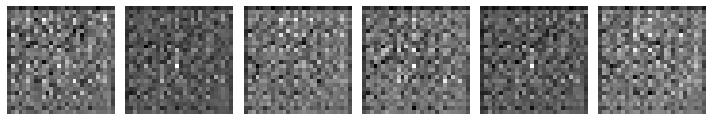

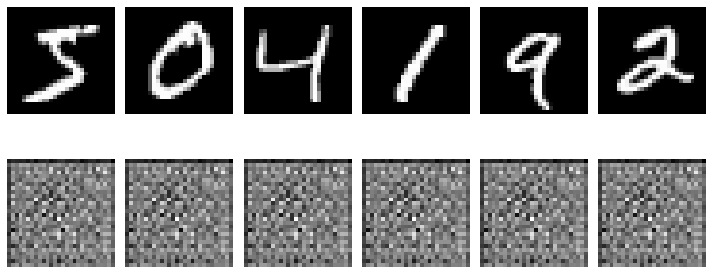

In [35]:
# Test 
model = model_dict_mnist['2d_stoch']
i = 0
for batch in mnist_train_loader: 
  callback(model, i, 42, batch[0])
  if i>=0:
    break

## MNIST

Epoch 0, batch loss: 438.47275


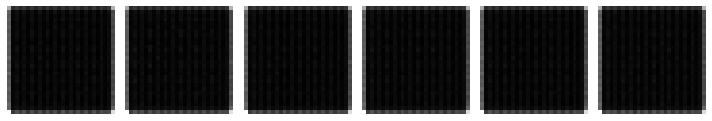

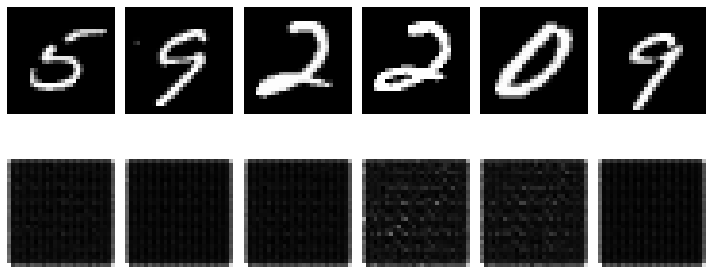

Epoch 1, batch loss: 437.21503


In [36]:

epochs = 2
model = model_dict_mnist['2d_det']
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = train_model(model, optimizer, mnist_train_loader, epochs, True, callback)


## CelebA

In [ ]:
epochs = 20
model = model_dict_celeba['200d_det']
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = train_model(model, optimizer, celeba_train_loader, epochs, False, callback)

In [ ]:
epochs = 20
model = model_dict_celeba['200d_stoch']
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = train_model(model, optimizer, celeba_train_loader, epochs, False, callback)

# Post-training

## Reconstructions

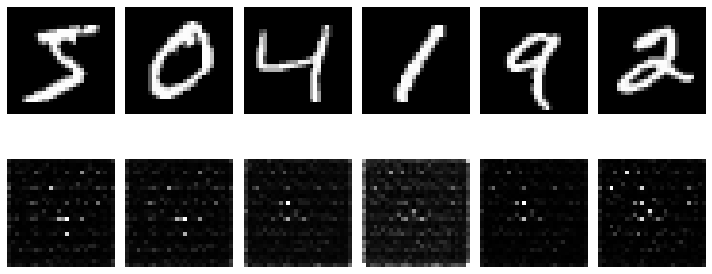

In [42]:
#generate_images(model, ttl)
model = model_dict_mnist['2d_det']
images = next(iter(mnist_train_loader))[0]
reconstruct_images(model, images, model.model_name)

## Generations

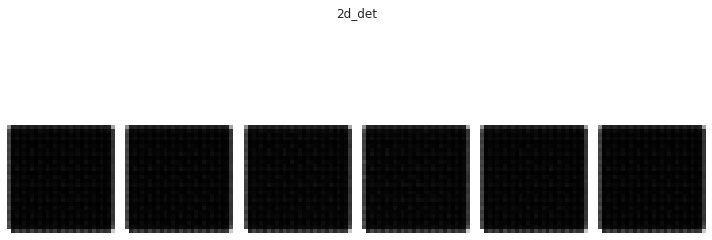

In [45]:
model = model_dict_mnist['2d_det']
generate_images(model, model.model_name)

# Latent space analysis

Illustrate latent space embedding and arithmetic for  VAE on CelebA faces images
Code is based on 
 https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_06_vae_faces_analysis.ipynb

In [46]:
# Make some wrapper functions so we can reuse code from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_faces_analysis.ipynb
  
N, H, W, C = images_celeba.shape
input_shape = (H,W,C)
INPUT_DIM = input_shape
DATA_FOLDER = ''
IMAGE_FOLDER = ''

def vae_encode(model, x):
    return model.encode(x)

def vae_decode(model, z_points):
    return model.decode(z_points)


In [47]:
print(input_shape)

(64, 64, 3)


In [48]:
att = pd.read_csv(csv_name)
att.head()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,...,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [49]:
class ImageLabelLoader():
  def __init__(self, image_folder, target_size):
    self.image_folder = image_folder
    self.target_size = target_size
  
  def build(self, att, batch_size, label = None):

    if label:
      images_celeba,labels = self.get_images(att,label)
      data_loader = DataLoader(Celeba_ano_ds(images_celeba,labels),batch_size= batch_size,shuffle=True)
    else:
      images_celeba = self.get_images(att)
      data_loader = DataLoader(Celeba_ds(images_celeba),batch_size= batch_size,shuffle=True)
      
    return data_loader

  def get_images(self,df,label=None):
    H,W,C = self.target_size
    images = np.zeros((len(df), H, W, C), dtype=np.float32) # pre-allocate memory
    labels = np.zeros(len(df))
    for i in range(N):
      filename = df.iloc[i]['image_id']
      img = imread(filename) # numpy array of uint8
      images[i,:,:] = img / 255
      if label:
        labels[i]= df.iloc[i][label]
    if label:
      return images,labels
    else:
      return images


imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM)

## Arithmetic in latent space

In [50]:


def get_vector_from_label(model, label, batch_size=500, att=att):
    latent_dim = model.latent_dim
    data_loader = imageLoader.build(att, batch_size, label = label)

    #origin = np.zeros(shape = latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = latent_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = latent_dim, dtype = 'float32')

    current_vector = np.zeros(shape = latent_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')

    while(current_n_POS < 10000):

        batch = next(iter(data_loader))
        im = batch[0]
        print(im.shape)
        attribute = batch[1]
        
        z = vae_encode(model, im)

        z = z.detach().numpy()
        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   




In [96]:
def add_vector_to_images(example_images, model, feature_vec, att=att):
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    transform=transforms.Compose([
        transforms.ToTensor(),
        ])
    n_to_show = len(example_images)
    input = torch.zeros(n_to_show, C, H, W)
    for i in range(n_to_show):
        input[i,:,:] = transform(example_images[i])

    #factors = [-4,-2,0,2,4]

    z_points = vae_encode(model, input)
    z_points = z_points.detach()
    for i in range(n_to_show):
      fig = plt.figure(figsize=(18, 8))
      counter = 1
      img = example_images[i].squeeze()
      sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
      sub.axis('off')        
      sub.imshow(img)
      counter += 1
      for factor in factors:
          changed_z_point = z_points[i] + feature_vec * factor
          changed_image = vae_decode(model, changed_z_point[None,:])[0]
          img = changed_image.detach()
          sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
          sub.axis('off')
          sub.imshow(torch.transpose(torch.transpose(img,0,2),0,1)[:, :, :])
          counter += 1
      plt.show()

In [57]:
print('Eyeglasses Vector')
#model = model_dict_celeba['200d_stoch']
model = model_dict_celeba['200d_det']
eyeglasses_vec = get_vector_from_label(model, 'Eyeglasses')


Eyeglasses Vector
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
torch.Size([500, 3, 64, 64])
27    : 7.887    : 1.231    : 7.029    : 7.029
torch.Size([500, 3, 64, 64])
56    : 4.13    : 0.978    : 3.426    : -3.603
torch.Size([500, 3, 64, 64])
89    : 1.879    : 0.464    : 2.335    : -1.09
torch.Size([500, 3, 64, 64])
115    : 0.725    : 0.428    : 1.887    : -0.448
torch.Size([500, 3, 64, 64])
147    : 0.487    : 0.334    : 1.476    : -0.412
torch.Size([500, 3, 64, 64])
175    : 0.443    : 0.258    : 1.269    : -0.207
torch.Size([500, 3, 64, 64])
204    : 0.408    : 0.207    : 1.138    : -0.131
torch.Size([500, 3, 64, 64])
243    : 0.495    : 0.196    : 1.056    : -0.082
torch.Size([500, 3, 64, 64])
283    : 0.482    : 0.166    : 0.972    : -0.084
torch.Size([500, 3, 64, 64])
313    : 0.146    : 0.156    : 0.878    : -0.093
torch.Size([500, 3, 64, 64])
349    : 0.179    : 0.142    : 0.804    : -0.075
torch.Size([500, 3, 64, 64])
381    : 0.106    : 0.131    : 

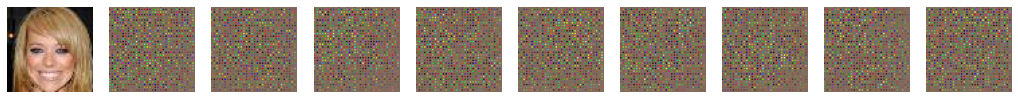

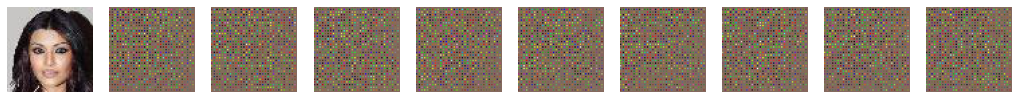

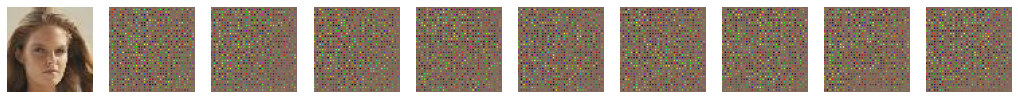

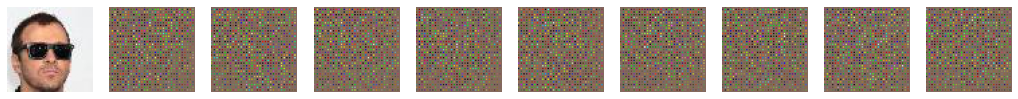

In [97]:

ndx = [112-1, 258-1, 238-1, 193-1] # blonde, black hair, brunette, male with glasses
add_vector_to_images(images_celeba[ndx], model, eyeglasses_vec)

In [98]:

print('Male Vector')
male_vec = get_vector_from_label(model, 'Male')


Male Vector
label: Male
images : POS move : NEG move :distance : 𝛥 distance
torch.Size([500, 3, 64, 64])
206    : 2.1    : 1.283    : 1.281    : 1.281
torch.Size([500, 3, 64, 64])
404    : 1.582    : 0.875    : 0.983    : -0.298
torch.Size([500, 3, 64, 64])
603    : 0.736    : 0.459    : 0.793    : -0.19
torch.Size([500, 3, 64, 64])
805    : 0.775    : 0.305    : 0.82    : 0.027
torch.Size([500, 3, 64, 64])
1020    : 0.41    : 0.302    : 0.663    : -0.157
torch.Size([500, 3, 64, 64])
1222    : 0.421    : 0.171    : 0.625    : -0.038
torch.Size([500, 3, 64, 64])
1428    : 0.31    : 0.187    : 0.568    : -0.057
torch.Size([500, 3, 64, 64])
1625    : 0.257    : 0.186    : 0.513    : -0.055
torch.Size([500, 3, 64, 64])
1819    : 0.238    : 0.127    : 0.483    : -0.03
torch.Size([500, 3, 64, 64])
2040    : 0.198    : 0.14    : 0.428    : -0.056
torch.Size([500, 3, 64, 64])
2251    : 0.224    : 0.081    : 0.423    : -0.005
torch.Size([500, 3, 64, 64])
2457    : 0.171    : 0.143    : 0.392   

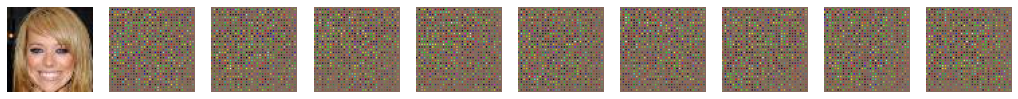

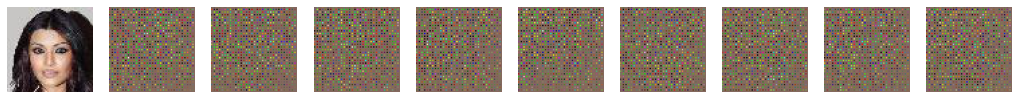

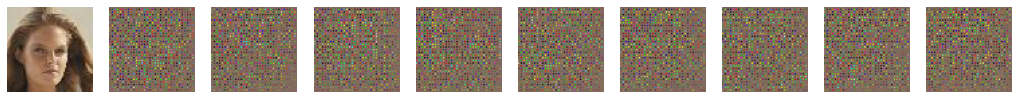

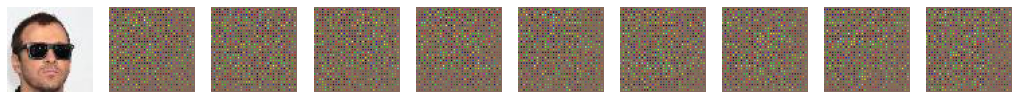

In [99]:
ndx = [112-1, 258-1, 238-1, 193-1] # blonde, black hair, brunette, male with glasses
add_vector_to_images(images_celeba[ndx], model, male_vec)

## Face interpolation

In [106]:
def morph_faces(start_image, end_image, model):
    #factors = np.arange(0, 1, 0.1)
    factors = np.arange(0, 1, 0.2)
    example_images = np.stack( (start_image, end_image), 0)
    transform=transforms.Compose([
        transforms.ToTensor(),
        ])
    n = len(example_images)
    input = torch.zeros(n, C, H, W)
    for i in range(n):
        input[i,:,:] = transform(example_images[i])

    z_points = vae_encode(model, input)

    fig = plt.figure(figsize=(18, 8))

    counter = 1
    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1
    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae_decode(model, changed_z_point[None,:])[0]
        img = changed_image.detach()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(torch.transpose(torch.transpose(img,0,2),0,1)[:, :, :])

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()


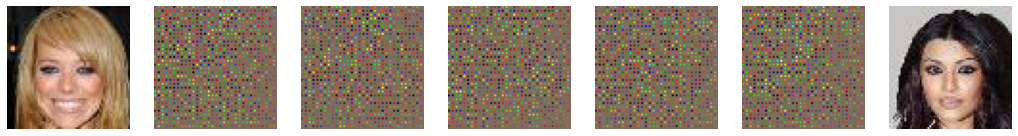

In [107]:
#model = model_dict_celeba['200d_stoch']
model = model_dict_celeba['200d_det']
start_image = images_celeba[112-1] # blonde
end_image = images_celeba[258-1] # brunette
morph_faces(start_image, end_image, model)

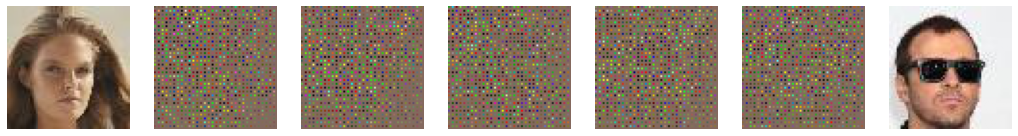

In [108]:
start_image = images_celeba[238-1] #female
end_image = images_celeba[193-1]  #male, glasses
morph_faces(start_image, end_image, model)